## Import

In [34]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

from tqdm import tqdm

#데이터 증강기법 활용을 위한 라이브러리 임포트
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, HorizontalFlip, Rotate, RandomBrightnessContrast,
    Resize, Normalize)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [35]:
DATA_DIR = './open'

x_train_dir = os.path.join(DATA_DIR, 'train_source_image')
y_train_dir = os.path.join(DATA_DIR, 'train_source_gt')

x_valid_dir = os.path.join(DATA_DIR, 'val_source_image')
y_valid_dir = os.path.join(DATA_DIR, 'val_source_gt')

x_test_dir = os.path.join(DATA_DIR, 'test_image')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')


In [36]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Utils

In [37]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [38]:
class Dataset(BaseDataset):
    CLASSES = ['Road', 'Sidewalk', 'Construction', 'Fence', 'Pole', 
               'Traffic Light', 'Traffic Sign', 'Nature', 'Sky', 
               'Person', 'Rider', 'Car']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            infer=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

        if masks_dir:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None
            
        self.infer = infer
        
        # If classes are not provided, default to all classes
        if not classes:
            classes = self.CLASSES

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.title()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Check if masks_fps is not None
        mask = None
        if self.masks_fps:
            mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
            # adjust mask values for 'unlabelled' class
            mask[mask == 255] = 12

        # apply augmentations
        if self.augmentation:
            if mask is not None:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.augmentation(image=image)['image']

        # apply preprocessing
        if self.preprocessing:
            if mask is not None:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.preprocessing(image=image)['image']

        return (image, mask) if mask is not None else image


        if self.infer:
            if self.augmentation:
                image = self.augmentation(image=image)['image']
            
    def __len__(self):
        return len(self.ids)


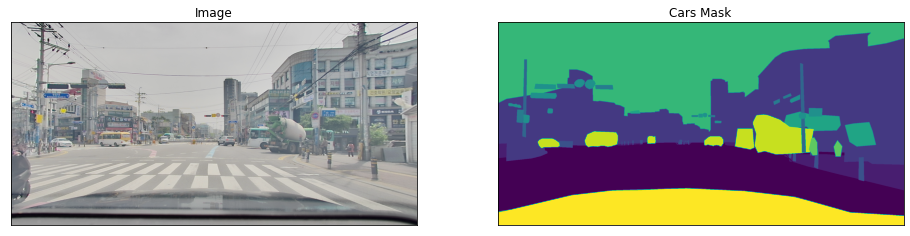

In [39]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [40]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.OpticalDistortion(p=1, distort_limit=5, shift_limit=5),  # OpticalDistortion 적용
        
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        #albu.PadIfNeeded(min_height=960, min_width=540, always_apply=True, border_mode=0),
        albu.CenterCrop(height=512, width=512, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape 224x224"""
    test_transform = [
        #albu.PadIfNeeded(960, 540),
        albu.CenterCrop(height=512, width=512, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    elif len(x.shape) == 2:
        return x.astype('float32')
    else:
        raise ValueError("Invalid array shape!")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(1024, 2048, 3)
(1024, 2048)


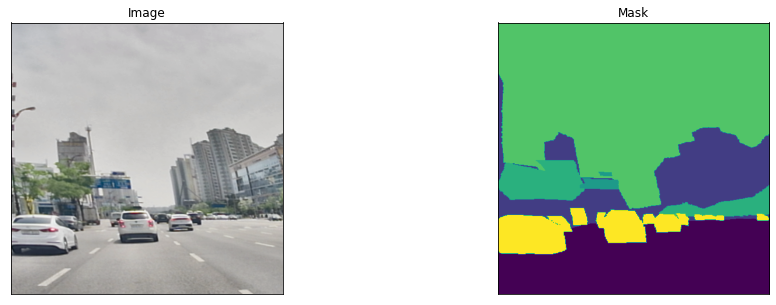

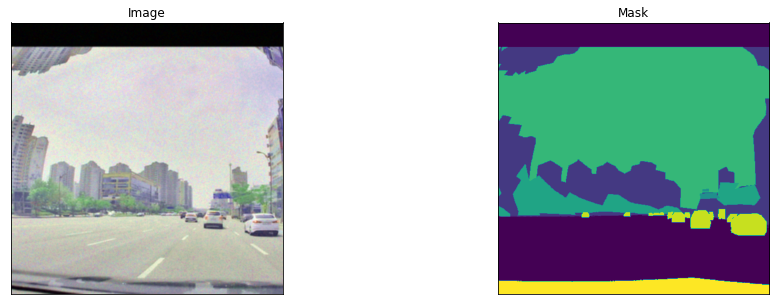

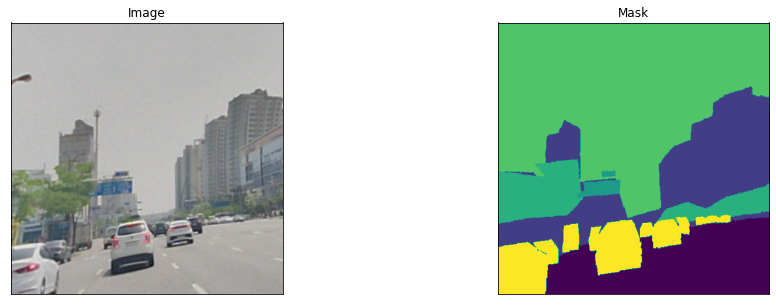

In [41]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation()
)
print(image.shape)
print(mask.shape)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask)

In [42]:
import sys

# 원하는 디렉토리 경로 추가
sys.path.append('/home/work/CPS_Project/Samsung AI-Challenge')

# 모듈 임포트
# from utils import your_util_function  # 필요한 함수 또는 클래스를 임포트

# 이제 해당 모듈의 함수나 클래스를 사용할 수 있습니다.

In [43]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [44]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 13
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=NUM_CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [45]:
print(model)

FPN(
  (encoder): SENetEncoder(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu)

In [46]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [47]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

for images, masks in valid_loader:
    print(images.shape, masks.shape)
    break

torch.Size([16, 3, 512, 512]) torch.Size([16, 512, 512])
torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])


In [48]:
mask_path = "/home/work/CPS_Project/Samsung AI-Challenge/open/train_source_gt/TRAIN_SOURCE_0024.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unique_values = np.unique(mask)
print(unique_values)

[  0   1   2   3   4   6   7   8  11 255]


In [49]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

device = DEVICE
criterion = torch.nn.CrossEntropyLoss()

In [50]:
# IoU 계산 함수
def iou_score(output, target):
    smooth = 1e-5

    n_classes = output.shape[1]
    ious = []

    for cls in range(n_classes):
        cls_output = output[:, cls, :, :]
        cls_target = (target == cls).float()

        intersection = (cls_output * cls_target).sum()
        union = cls_output.sum() + cls_target.sum() - intersection

        ious.append((intersection + smooth) / (union + smooth))

    return sum(ious) / len(ious)

# 초기 설정
best_miou = 0
save_path = './Samsung_best_model5.pth'
model = model.to(device)

# 학습 루프
for epoch in range(20):
    model.train()
    epoch_loss = 0
    total_iou = 0

    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_iou += iou_score(outputs.detach(), masks.squeeze(1).detach())

    avg_miou = total_iou / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, mIoU: {avg_miou}')
    
    # Validation and Save best model
    model.eval()
    total_val_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.float().to(device)
            masks = masks.long().to(device)
            outputs = model(images)
            total_val_iou += iou_score(outputs, masks.squeeze(1))
    avg_val_miou = total_val_iou / len(valid_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(valid_loader)}, mIoU: {avg_val_miou}')
    print(f'Validation mIoU: {avg_val_miou}')

    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(model.state_dict(), save_path)
        print(f'Model saved at {save_path} with mIoU: {best_miou}')

    # 30 epochs마다 learning rate 조정
    if (epoch+1) % 30 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f'Learning rate reduced to {param_group["lr"]}')


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 1, Loss: 1.8704164684682651, mIoU: 0.276702344417572


100%|██████████| 466/466 [00:19<00:00, 23.36it/s]


Epoch 1, Loss: 0.5539001558983275, mIoU: 0.27806153893470764
Validation mIoU: 0.27806153893470764
Model saved at ./Samsung_best_model5.pth with mIoU: 0.27806153893470764


100%|██████████| 138/138 [01:53<00:00,  1.21it/s]


Epoch 2, Loss: 1.8278043615645256, mIoU: 0.30134138464927673


100%|██████████| 466/466 [00:19<00:00, 23.50it/s]


Epoch 2, Loss: 0.541281119948293, mIoU: 0.28144392371177673
Validation mIoU: 0.28144392371177673
Model saved at ./Samsung_best_model5.pth with mIoU: 0.28144392371177673


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 3, Loss: 1.8226878029712732, mIoU: 0.3046121895313263


100%|██████████| 466/466 [00:19<00:00, 23.47it/s]


Epoch 3, Loss: 0.5397659159013641, mIoU: 0.2808019518852234
Validation mIoU: 0.2808019518852234


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 4, Loss: 1.8133590541024138, mIoU: 0.31031063199043274


100%|██████████| 466/466 [00:19<00:00, 23.44it/s]


Epoch 4, Loss: 0.5370033250346204, mIoU: 0.2897752821445465
Validation mIoU: 0.2897752821445465
Model saved at ./Samsung_best_model5.pth with mIoU: 0.2897752821445465


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 5, Loss: 1.8077411262885383, mIoU: 0.31391653418540955


100%|██████████| 466/466 [00:19<00:00, 23.37it/s]


Epoch 5, Loss: 0.5353396468408118, mIoU: 0.2860804796218872
Validation mIoU: 0.2860804796218872


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 6, Loss: 1.8082123977550562, mIoU: 0.3142675757408142


100%|██████████| 466/466 [00:19<00:00, 23.44it/s]


Epoch 6, Loss: 0.5354792079188793, mIoU: 0.2923155426979065
Validation mIoU: 0.2923155426979065
Model saved at ./Samsung_best_model5.pth with mIoU: 0.2923155426979065


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 7, Loss: 1.802522081395854, mIoU: 0.31788650155067444


100%|██████████| 466/466 [00:19<00:00, 23.41it/s]


Epoch 7, Loss: 0.5337940927738796, mIoU: 0.2920268774032593
Validation mIoU: 0.2920268774032593


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 8, Loss: 1.8061412581499072, mIoU: 0.31523045897483826


100%|██████████| 466/466 [00:19<00:00, 23.47it/s]


Epoch 8, Loss: 0.5348658661473974, mIoU: 0.2915046513080597
Validation mIoU: 0.2915046513080597


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 9, Loss: 1.7941301680993342, mIoU: 0.35544252395629883


100%|██████████| 466/466 [00:19<00:00, 23.46it/s]


Epoch 9, Loss: 0.5313089339006613, mIoU: 0.2946065068244934
Validation mIoU: 0.2946065068244934
Model saved at ./Samsung_best_model5.pth with mIoU: 0.2946065068244934


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 10, Loss: 1.7837572166885154, mIoU: 0.38718512654304504


100%|██████████| 466/466 [00:19<00:00, 23.39it/s]


Epoch 10, Loss: 0.5282371156717063, mIoU: 0.29639920592308044
Validation mIoU: 0.29639920592308044
Model saved at ./Samsung_best_model5.pth with mIoU: 0.29639920592308044


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 11, Loss: 1.780954576920772, mIoU: 0.38923022150993347


100%|██████████| 466/466 [00:19<00:00, 23.44it/s]


Epoch 11, Loss: 0.5274071493885548, mIoU: 0.2852199971675873
Validation mIoU: 0.2852199971675873


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 12, Loss: 1.7822301223658132, mIoU: 0.3897300958633423


100%|██████████| 466/466 [00:19<00:00, 23.48it/s]


Epoch 12, Loss: 0.5277848860224941, mIoU: 0.29434338212013245
Validation mIoU: 0.29434338212013245


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 13, Loss: 1.7781583675439807, mIoU: 0.3901996910572052


100%|██████████| 466/466 [00:19<00:00, 23.39it/s]


Epoch 13, Loss: 0.526579087384269, mIoU: 0.29568812251091003
Validation mIoU: 0.29568812251091003


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 14, Loss: 1.7780087633409363, mIoU: 0.3926837742328644


100%|██████████| 466/466 [00:19<00:00, 23.45it/s]


Epoch 14, Loss: 0.5265347839936678, mIoU: 0.29254767298698425
Validation mIoU: 0.29254767298698425


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 15, Loss: 1.7946896984957266, mIoU: 0.3773038387298584


100%|██████████| 466/466 [00:19<00:00, 23.47it/s]


Epoch 15, Loss: 0.5314746317433697, mIoU: 0.29375144839286804
Validation mIoU: 0.29375144839286804


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 16, Loss: 1.7818916163582732, mIoU: 0.3892243206501007


100%|██████████| 466/466 [00:19<00:00, 23.41it/s]


Epoch 16, Loss: 0.5276846417541667, mIoU: 0.2941097617149353
Validation mIoU: 0.2941097617149353


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 17, Loss: 1.7885087763053784, mIoU: 0.3838600516319275


100%|██████████| 466/466 [00:19<00:00, 23.38it/s]


Epoch 17, Loss: 0.5296442298930091, mIoU: 0.2946544587612152
Validation mIoU: 0.2946544587612152


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 18, Loss: 1.776791164840477, mIoU: 0.394741952419281


100%|██████████| 466/466 [00:19<00:00, 23.38it/s]


Epoch 18, Loss: 0.5261742076137035, mIoU: 0.2972985506057739
Validation mIoU: 0.2972985506057739
Model saved at ./Samsung_best_model5.pth with mIoU: 0.2972985506057739


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 19, Loss: 1.772632947002632, mIoU: 0.3993721902370453


100%|██████████| 466/466 [00:19<00:00, 23.42it/s]


Epoch 19, Loss: 0.5249428040479898, mIoU: 0.29617583751678467
Validation mIoU: 0.29617583751678467


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 20, Loss: 1.774507086346115, mIoU: 0.3952442705631256


100%|██████████| 466/466 [00:19<00:00, 23.46it/s]

Epoch 20, Loss: 0.5254978066861885, mIoU: 0.2963102161884308
Validation mIoU: 0.2963102161884308


In [51]:
with torch.no_grad():
    model.eval()
    images = images.to('cuda')  
    outputs = model(images)
    print(outputs.shape)
    

torch.Size([1, 13, 512, 512])


In [52]:
# load best saved checkpoint
best_model = torch.load('./Samsung_best_model4.pth')

## Inference

In [53]:
test_dataset = Dataset(
    x_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    infer=True,
)

#test_dataset = CustomDataset(csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [54]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]/tmp/ipykernel_1013721/4045914463.py:13: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
100%|██████████| 119/119 [02:52<00:00,  1.45s/it]


## Submission

In [55]:
submit = pd.read_csv('/home/work/CPS_Project/Samsung AI-Challenge/open/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,155905 4 155926 8 156845 105 157805 105 158746...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,65 73 408 148 667 294 1027 73 1366 150 1623 29...
3,TEST_0000_class_3,-1
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,31542 11 31632 11 32491 36 32572 41 33447 45 3...
22772,TEST_1897_class_8,142 673 1104 671 2064 669 3025 668 3985 668 49...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [56]:
submit.to_csv('./baseline_submit_9(New_Model).csv', index=False)